In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from FRED_data_pull import *
from pathlib import Path
from datetime import datetime, timedelta
import os
import dotenv
dotenv.load_dotenv()
api_key = os.environ['FRED_API_KEY']
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error

from pandas.tseries.offsets import MonthEnd

In [2]:
monthly_df = pull_data(['GASDESW'],
                 'm', api_key)
monthly_df.loc[monthly_df.index[0] + MonthEnd(1)] = np.nan
#monthly_df.loc[monthly_df.index[0] + MonthEnd(2)] = np.nan
monthly_df = monthly_df.sort_index().shift(1).dropna()

C:\Users\alex.zhang\AppData\Local\anaconda3\envs\ai\lib\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.stlouisfed.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [3]:
file_path = Path("Monthly Input Data.xlsx")
ppi_df = pd.read_excel(file_path).set_index('date')[::-1]
file_path = Path("Quarterly Input Data.xlsx")
qtr_df = pd.read_excel(file_path).set_index('date')[::-1]
monthly_df['ppi'] = ppi_df

In [4]:
monthly_df = (monthly_df / monthly_df.shift(12) - 1)
qtr_df = (qtr_df / qtr_df.shift(4) - 1).dropna()

In [5]:
#qtr_df['Average'] = qtr_df.mean(axis=1)
#qtr_df = qtr_df.drop(columns=['JBHT', 'NSC', 'CSX', 'UNP'])

In [6]:
for i in range(1):
    col_names = ['date'] + list(qtr_df.columns)
    new_row = pd.DataFrame([[np.nan]*len(col_names)], columns = col_names)
    new_row['date'] = qtr_df.index[-1] + MonthEnd(3)
    new_row = new_row.set_index('date')
    qtr_df = pd.concat([qtr_df, new_row])

In [7]:
monthly_df.index.freq = 'M'
qtr_df.index.freq = 'Q'

monthly_df = monthly_df[monthly_df.index >= '2004-01-31']
#monthly_df = monthly_df[monthly_df.index <= '2024-06-30']
#qtr_df = qtr_df[qtr_df.index >= '1998-12-31']

In [8]:
cutoff = 1
cutoff_date = qtr_df.dropna().index[-cutoff]
const_pre = np.ones(len(monthly_df[:-cutoff]))
model = sm.tsa.DynamicFactorMQ(monthly_df[monthly_df.index <= cutoff_date], endog_quarterly=qtr_df[qtr_df.index <= cutoff_date], factors=1, factor_orders=1, factor_multiplicities=1, freq = 'M')#, enforce_stationarity=False)
#model = sm.tsa.DynamicFactor(monthly_df[:-cutoff], endog_quarterly = qtr_df, exog=const_pre, k_factors=1, factor_order=3)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of monthly variables:                      2
                   + 1 factors in 1 blocks   # of quarterly variables:                    4
                   + Mixed frequency (M/Q)   # of factors:                                1
                     + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                            2004-01   Standardize variables:                    True
                                 - 2024-06                                                 
Observed variables / factor loadings
========================
Dep. variable          0
------------------------
      GASDESW          X
          ppi          X
         JBHT          X
          NSC          X
          CSX          X
          UNP          X
    Factor blocks:   
=====================
     block      order
---------------------
         0          1
=====================
"""

In [9]:
results = model.fit(maxiter=1000000, disp=100, method='powell')

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.498672
         Iterations: 6
         Function evaluations: 1507
                               Dynamic Factor Results                              
Dep. Variable:       "GASDESW", and 5 more   No. Observations:                  246
Model:                Dynamic Factor Model   Log Likelihood                -122.673
                   + 1 factors in 1 blocks   AIC                            285.346
                   + Mixed frequency (M/Q)   BIC                            355.453
                     + AR(1) idiosyncratic   HQIC                           313.575
Date:                     Wed, 04 Dec 2024                                         
Time:                             01:38:46                                         
Sample:                         01-31-2004                                         
                              - 06-30-2024                                         
Covariance Type:     

In [10]:
#if cutoff > 2:
#    results_appended = results.append(endog = monthly_input[monthly_input.index > cutoff_date], 
#                                      endog_quarterly = quarterly_input[quarterly_input.index > cutoff_date])
#else:
results_appended = results

# Specify the number of steps ahead you want to forecast
steps_ahead = 12  # For example, forecasting 12 months ahead
const_forecast = np.ones(steps_ahead)
# Generate forecasts
forecasts = results_appended.forecast(steps=steps_ahead)

forecast_dates = [cutoff_date + MonthEnd(i) for i in range(1, steps_ahead + 1)]

forecasts.index = forecast_dates

# The 'forecasts' variable now contains the forecasted values for each variable for the next 12 months
print(forecasts)


             GASDESW       ppi      JBHT       NSC       CSX       UNP
2024-07-31 -0.019041  0.009570 -0.024727 -0.051769 -0.000661 -0.014084
2024-08-31 -0.014577  0.010247 -0.010022 -0.032134  0.007057 -0.000996
2024-09-30 -0.010347  0.010938 -0.003172 -0.022170  0.007067  0.006053
2024-10-31 -0.006334  0.011638 -0.001656 -0.018195  0.003396  0.008698
2024-11-30 -0.002523  0.012344 -0.001008 -0.015566  0.000127  0.010320
2024-12-31  0.001099  0.013052 -0.000282 -0.013177 -0.002009  0.011717
2025-01-31  0.004544  0.013759  0.000503 -0.010998 -0.003322  0.012976
2025-02-28  0.007822  0.014462  0.001332 -0.009003 -0.004041  0.014143
2025-03-31  0.010944  0.015159  0.002193 -0.007170 -0.004333  0.015240
2025-04-30  0.013919  0.015849  0.003074 -0.005481 -0.004322  0.016282
2025-05-31  0.016756  0.016529  0.003968 -0.003919 -0.004097  0.017276
2025-06-30  0.019463  0.017199  0.004865 -0.002471 -0.003723  0.018226


## Update Forecast

In [11]:
#start_date = str(data.index[-1])[:7]
#end_date = str(data.index[-1] + timedelta(32))[:7]
def get_news(data, data_quarterly, results, lookback=1, steps_ahead = 1):
    start_date = data_quarterly.dropna().index[-lookback]
    print(start_date)
    end_date = start_date + MonthEnd(steps_ahead*3)
    #end_date = start_date + relativedelta(months=lookback*3+1)
    #end_date = datetime(end_date.year, end_date.month, 1) - timedelta(days=1)
    print(end_date)
    #print(results.summary())

    #const_post_plus1 = np.ones(len(data) + 1)
    news = results.news(data, endog_quarterly = data_quarterly, start=start_date, end=end_date)
    return news

news = get_news(monthly_df, qtr_df, results_appended)

print(news.summary())

2024-06-30 00:00:00
2024-09-30 00:00:00
                                      News                                     
Model:                DynamicFactorMQ   Original sample:                2004-01
Date:                Wed, 04 Dec 2024                                 - 2024-06
Time:                        01:38:47   Update through:                 2024-12
                                        # of revisions:                       0
                                        # of new datapoints:                  9
                                  Impacts                                  
impact date impacted variable estimate (prev) impact of news estimate (new)
---------------------------------------------------------------------------
    2024-07               CSX           -0.00           0.00          -0.00
                      GASDESW           -0.02          -0.00          -0.02
                         JBHT           -0.02           0.00          -0.02
                        

In [12]:
def update_forecast_data(forecast_df, news):#,length=2):
    #if length < 2:
    #    length = 2
    
    new_df = forecast_df.copy()
    #num_cols = len(new_df.columns)
    for i in range(len(news.impacts)):
        revision_date = news.impacts.index[i][0]
        revision_date = pd.to_datetime(str(revision_date) + "-01") + MonthEnd(1)
        #print(revision_date)
        col_name = news.impacts.index[i][1]
        new_df.loc[revision_date, col_name] = news.impacts.iloc[i,4]
    return new_df


def combine_data(history_df, forecast_df):
    #print(data)
    num_cols = len(history_df.columns)
    if num_cols == len(forecast_df.columns):
        new_df = pd.concat([history_df, forecast_df])
        #new_df = new_df[~new_df.index.duplicated(keep='first')]
        for i in range(num_cols):
            for j in range(1, len(forecast_df)+1):
                if np.isnan(new_df.iloc[-j,i]):
                    new_df.iloc[-j,i] = forecast_df.iloc[-j,i]
        return new_df
    else:
        raise ValueError()

new_forecasts = update_forecast_data(forecasts, news)
#new_forecasts.index = new_forecasts.index.to_timestamp('M')
new_forecasts_quarterly = new_forecasts[qtr_df.columns].resample('Q').last()
new_data = combine_data(qtr_df, new_forecasts_quarterly)
new_data.tail(10)

,JBHT,NSC,CSX,UNP
2023-06-30,-0.127012,-0.158086,-0.093111,-0.140655
2023-09-30,-0.162939,-0.211706,-0.078755,-0.126924
2023-12-31,-0.128263,-0.170960,-0.036649,-0.093477
2024-03-31,-0.091941,-0.151410,-0.053960,-0.067822
2024-06-30,-0.046785,-0.081541,-0.017509,-0.032419
2024-09-30,NaN,NaN,NaN,NaN
2024-09-30,-0.008718,-0.027002,0.002883,0.001363
2024-12-31,-0.000282,-0.013177,-0.002009,0.011717
2025-03-31,0.002193,-0.007170,-0.004333,0.015240
2025-06-30,0.004865,-0.002471,-0.003723,0.018226


## Recursive Estimation

In [13]:
def recursive_estimation(data_monthly, data_quarterly, y_names: list, factors = 1, factor_orders = 3, factor_multiplicities = 1, steps_ahead = 1, start_point = 50, missing_vars_q = None, missing_vars_m = None):

    for y_name in y_names:
        if (y_name not in data_monthly.columns) and (y_name not in data_quarterly.columns):
            raise ValueError()
    
    # Find missing vars based on distance from last quarter of full data if no missing vars are inputted 
   # cutoff_date = data_quarterly.dropna().index[-1]
    #next_quarter = cutoff_date+MonthEnd(steps_ahead*3)

    num_blanks_q = len(data_quarterly) - len(data_quarterly.dropna())
    if missing_vars_q is None:
        #missing_vars_q = quarterly_input[quarterly_input.index <= next_quarter].iloc[-num_blanks:].isna().reset_index(drop = True)
        missing_vars_q = quarterly_input.iloc[-num_blanks_q:].isna().reset_index(drop = True)

    num_blanks_m = len(data_monthly) - len(data_monthly.dropna())
    if missing_vars_m is None:
        #missing_vars_m = monthly_input[monthly_input.index <= next_quarter].iloc[-num_blanks*3:].isna().reset_index(drop = True)
        missing_vars_m = monthly_input.iloc[-num_blanks_m:].isna().reset_index(drop = True)

    #if data.index[2] != data_quarterly.index[0]:
        

    #all_columns = list(data_monthly.columns) + list(data_quarterly.columns)
    errors_df = pd.DataFrame(0, index=range(steps_ahead), columns=data_quarterly.columns)
    preds_dfs = [pd.DataFrame(columns=data_quarterly.columns)]*steps_ahead

    if steps_ahead > num_blanks_q:
        T = steps_ahead
    else:
        T = num_blanks_q
    
    for i in range(start_point, len(data_quarterly.dropna())-steps_ahead+1):
    #for i in range(start_point, len(data_quarterly.dropna())-T+1):
        print(len(data_quarterly.dropna()) - i)
        #print(i)
        print(f"Training Sample Ending {str(data_quarterly[:i].index[-1])}")
        model = sm.tsa.DynamicFactorMQ(data_monthly[:i*3], endog_quarterly = data_quarterly[:i], factors=1, factor_orders=factor_orders, factor_multiplicities = factor_multiplicities)#,enforce_stationarity=False)
        results = model.fit(maxiter=100000, disp=100, method='powell')

        # Generate forecasts and adjust datetime index to be compatible with rest of data
        forecasts = results.forecast(steps=steps_ahead*3)
        forecast_dates = [data_quarterly.index[i-1] + MonthEnd(k) for k in range(1, steps_ahead*3 + 1)]
        forecasts.index = forecast_dates
        #print(forecasts)

        if missing_vars_q.any().any() or missing_vars_m.any().any():

            # Extend monthly data to include "news"
            #new_cutoff_m = (i+steps_ahead)*3
            new_cutoff_m = i*3+num_blanks_m
            new_data_monthly = data_monthly.copy()[:new_cutoff_m]

            # Extend quarterly data to include "news"
            #new_cutoff_q = i_steps_ahead
            new_cutoff_q = i+num_blanks_q
            new_data_quarterly = data_quarterly.copy()[:new_cutoff_q]

            # Replace values in new monthly data with NAs based on inputted missing variables
            for j, _ in enumerate(new_data_monthly.columns):
                for k in range(num_blanks_m):
                    if missing_vars_m.iloc[k, j] == True:
                        new_data_monthly.iloc[i*3+k, j] = np.nan

           # Replace values in new quarterly data with NAs based on inputted missing variables
            for j, _ in enumerate(new_data_quarterly.columns):
                for k in range(num_blanks_q):
                    if missing_vars_q.iloc[k, j] == True:
                        new_data_quarterly.iloc[i+k, j] = np.nan

            news = get_news(new_data_monthly, new_data_quarterly, results, steps_ahead = steps_ahead)
            #print(new_data_quarterly)
            #print(new_data_monthly)
            #print(news.summary())
            forecasts = update_forecast_data(forecasts, news)
            #print(forecasts)
            #forecasts.index = forecasts.index.to_timestamp('M')
            forecasts = forecasts[data_quarterly.columns].resample('Q').last()
            forecasts = forecasts[:steps_ahead]
            print(forecasts)
            
        # Compare Observed Values with Forecast and Record Results
        observed = data_quarterly.copy()[i:i+steps_ahead]
        has_nans = observed.isna().any().any()
        if not has_nans:
            error = (forecasts - observed).reset_index(drop = True)
            errors_df = errors_df + error**2
        #display(errors_df)
        
        for k in range(steps_ahead):
            preds_dfs[k] = pd.concat([preds_dfs[k], forecasts[k:k+1]])

    errors_df = (errors_df / (len(data_quarterly.dropna()) - start_point - steps_ahead + 1))**0.5
    
    errors_df = errors_df[y_names]
        
    return preds_dfs, errors_df

In [14]:
steps_ahead = 2

#next_quarter = cutoff_date+MonthEnd(steps_ahead*3)

start_index=50
start_point = len(qtr_df.dropna()) - start_index

num_blanks_q = len(qtr_df) - len(qtr_df.dropna())
#missing_vars_q = quarterly_input[quarterly_input.index <= next_quarter].iloc[-num_blanks:].isna().reset_index(drop = True)
missing_vars_q = qtr_df.iloc[-num_blanks_q:].isna().reset_index(drop = True)

num_blanks_m = len(monthly_df) - len(monthly_df.dropna())
#missing_vars_m = monthly_input[monthly_input.index <= next_quarter].iloc[-num_blanks*3:].isna().reset_index(drop = True)
missing_vars_m = monthly_df.iloc[-num_blanks_m:].isna().reset_index(drop = True)

y_names = ['JBHT','NSC','UNP','CSX']
#y_names = ['Average']
preds_dfs, errors_df = recursive_estimation(monthly_df,
                                            qtr_df,
                                            y_names,
                                            factors = 1,
                                            factor_orders = 1,
                                            factor_multiplicities = 1,
                                            steps_ahead = steps_ahead,
                                            start_point = start_point,
                                            missing_vars_q = missing_vars_q,
                                            missing_vars_m = missing_vars_m)

50
Training Sample Ending 2011-12-31 00:00:00
Optimization terminated successfully.
         Current function value: 1.154324
         Iterations: 6
         Function evaluations: 1516
2011-12-31 00:00:00
2012-06-30 00:00:00
                JBHT       NSC       CSX       UNP
2012-03-31  0.038664  0.043136  0.099181  0.100269
2012-06-30  0.018430  0.029728  0.036379  0.062563
49
Training Sample Ending 2012-03-31 00:00:00
Optimization terminated successfully.
         Current function value: 1.159814
         Iterations: 6
         Function evaluations: 1511
2012-03-31 00:00:00
2012-09-30 00:00:00
                JBHT       NSC       CSX       UNP
2012-06-30 -0.000433  0.009796  0.020823  0.071442
2012-09-30 -0.018022 -0.000971 -0.010746  0.041815
48
Training Sample Ending 2012-06-30 00:00:00
Optimization terminated successfully.
         Current function value: 1.159779
         Iterations: 6
         Function evaluations: 1508
2012-06-30 00:00:00
2012-12-31 00:00:00
                JBH

In [15]:
errors_df

,JBHT,NSC,UNP,CSX
0,0.029103,0.030195,0.036805,0.027085
1,0.058827,0.060394,0.055778,0.041399


In [16]:
preds_dfs[0]

,JBHT,NSC,CSX,UNP
2012-03-31,0.038664,0.043136,0.099181,0.100269
2012-06-30,-0.000433,0.009796,0.020823,0.071442
2012-09-30,-0.023303,-0.016474,-0.015479,0.036479
2012-12-31,0.020150,0.020837,0.023444,0.064410
2013-03-31,0.004126,-0.006957,-0.000065,0.036285
2013-06-30,-0.010503,-0.006957,-0.008013,0.037562
2013-09-30,-0.003037,-0.001707,0.007771,0.029980
2013-12-31,-0.014585,-0.012340,-0.003843,0.021967
2014-03-31,-0.018983,0.004052,-0.021132,0.007572
2014-06-30,0.000736,0.000487,-0.008274,0.038303


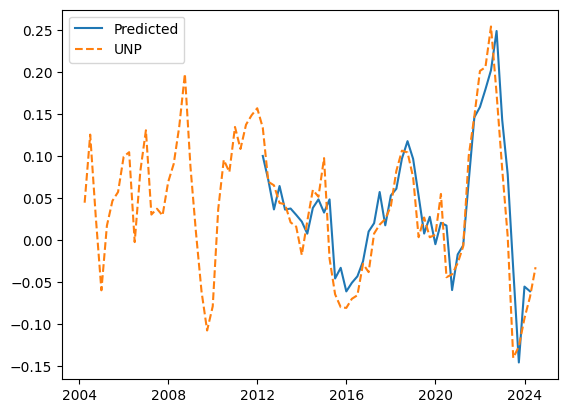

In [19]:
ticker = 'UNP'
plt.plot(preds_dfs[0].index, preds_dfs[0][ticker], label='Predicted')
plt.plot(qtr_df.index, qtr_df[ticker], label=ticker, linestyle='--')
plt.legend()
plt.show()

In [18]:
preds_dfs[0].reset_index().rename(columns={'index':'date'}).to_csv('YoY_Model_Preds.csv')